In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Normalización
from sklearn.preprocessing import StandardScaler

# Reducción de Dimensionalidad
from umap import UMAP
from sklearn.decomposition import PCA

# Fuzzy Clustering
import skfuzzy as fuzz

# Metricas
from sklearn.metrics import rand_score, adjusted_rand_score



In [3]:
def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = rand_score(Labels_orig, Labels_clust)
    arand= adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct


In [4]:
# Selecciono N filas de cada archivo input. 

DEFAULT_LENGTH = 15000 
SAMPLE_LENGTH = 10000

prefijo = "features_completos_"
sufijo = ".csv.gz"
clases = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]
input_folder = "output/datasets/"
input_paths = [input_folder+prefijo+c+sufijo for c in clases]


sample_df = pd.DataFrame()
for clase in clases:
    path = input_folder+prefijo+clase+sufijo
    ids = np.random.choice(np.arange(0,DEFAULT_LENGTH,1), size=SAMPLE_LENGTH, replace=False)
    df = pd.read_csv(path) 
    df = df.loc[ids, :].reset_index(drop=True)
    sample_df = pd.concat([sample_df, df], axis=0)
    print(clase, sample_df.shape)



Arborio (10000, 4097)
Basmati (20000, 4097)
Ipsala (30000, 4097)
Jasmine (40000, 4097)
Karacadag (50000, 4097)


In [5]:
default_cols = ['image_id','class_name']
morphological_features = ['area','eccentricity','perimeter', 'orientation','axis_major_length','axis_minor_length']
conv2d_features = [str(i) for i in range(4096)]

#sample_features = sample_df.copy()
#sample_labels = ([clases[0]]*SAMPLE_LENGTH + [clases[1]]*SAMPLE_LENGTH + [clases[2]]*SAMPLE_LENGTH + [clases[3]]*SAMPLE_LENGTH + [clases[4]]*SAMPLE_LENGTH)

sample_features = sample_df.drop(columns = default_cols + morphological_features)
sample_labels = sample_df.class_name.to_list()

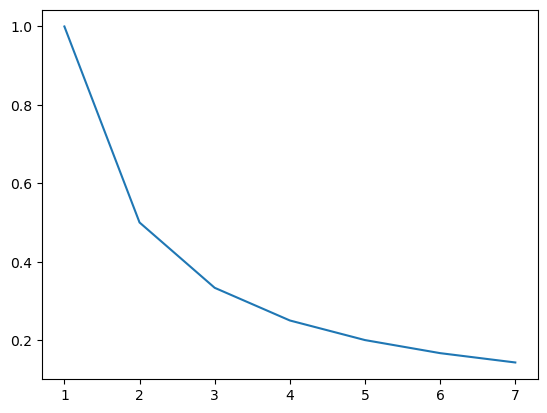

In [6]:
# Uso PCA

ncols = sample_features.shape[1]
n_components = np.min([100, ncols])

scaler = StandardScaler()
scaled = scaler.fit_transform(sample_features)

pca = PCA(n_components=n_components)
scaled_pca = pca.fit(scaled)
Xpca = pca.transform(scaled)

exp_var = scaled_pca.explained_variance_ratio_
# varexp_acum = np.cumsum(exp_var)

# fig, ax = plt.subplots()
# ax.plot(varexp_acum)
# ax.set_title('Varianza Explicada Acumulada', fontsize=8)
# plt.show()

FPCs = []
for n in np.r_[1:8]:
    n_clusters = n
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(Xpca.T, 
                                                    n_clusters, 
                                                    2, 
                                                    error=0.0005, 
                                                    maxiter=1000, 
                                                    init=None)
    FPCs.append(fpc)


fig, ax = plt.subplots()
ax.plot(np.r_[1:8], FPCs)

In [7]:
# defino paleta categorica
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)
paleta = sns.color_palette(palette=plt.cm.tab20(np.arange(5)))

C:\Users\jfgonzalez\AppData\Local\Temp\ipykernel_6496\1250006164.py:14: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = cluster_membership, s=5, alpha=0.5, ax=ax2, palette=paleta)


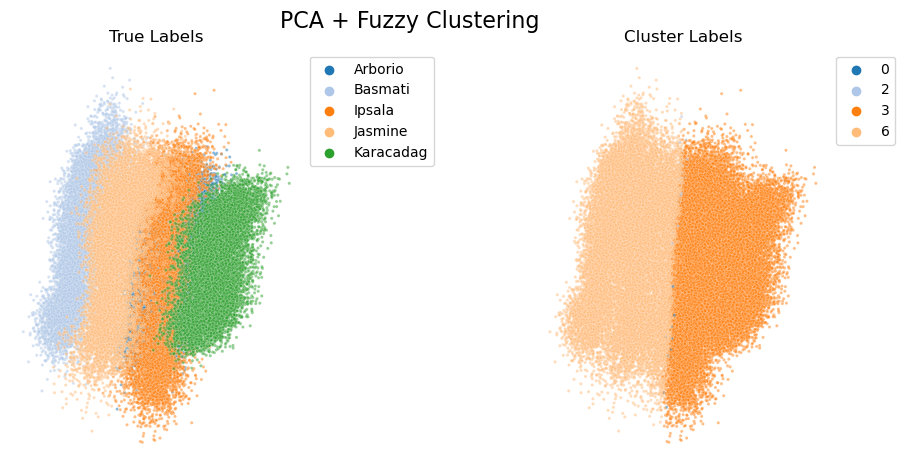

In [8]:
# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

# fig, ax = plt.subplots()
# ax = sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = sample_labels)
# ax.set_xlabel(f"PC1 ({'{0:.2f}%'.format(exp_var[0]*100)})")
# ax.set_ylabel(f"PC2 ({'{0:.2f}%'.format(exp_var[1]*100)})")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = sample_labels,s=5, alpha=0.5, ax=ax1, palette=paleta)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = cluster_membership, s=5, alpha=0.5, ax=ax2, palette=paleta)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
fig.suptitle("PCA + Fuzzy Clustering", fontsize=16)
ax1.set_title("True Labels")
ax1.axis('off')
ax2.set_title("Cluster Labels")
ax2.axis('off')
plt.subplots_adjust(left=0.1, wspace=0.8, top=0.9)
plt.show()

In [9]:
cross_tab(Labels_orig=sample_labels, Labels_clust=cluster_membership)

RAND score=0.6487, Ajusted RAND=0.2990, cantidad_de_muestras=50,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,5,0,10,1,0
2,3,0,24,13,0
3,8437,0,8184,270,10000
6,1555,10000,1782,9716,0


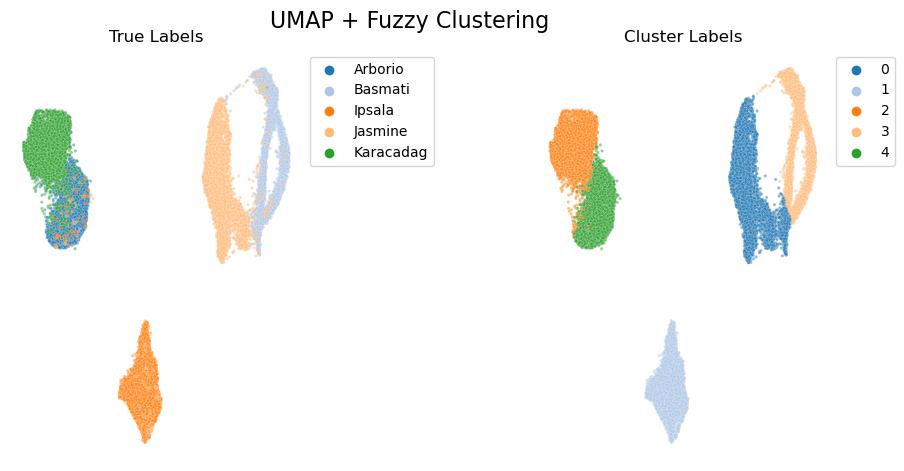

In [10]:
# Uso UMAP

umap = UMAP(
    n_neighbors=100,
    min_dist=0.1,
    n_components=3,
    random_state = 21
)

# Hago el fuzzy clustering
standard_embedding = umap.fit_transform(Xpca)
n_clusters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(standard_embedding.T, 
                                                 n_clusters, 
                                                 2, 
                                                 error=0.005, 
                                                 maxiter=1000, 
                                                 init=None)

# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = sample_labels,
                s=5, alpha=0.5, ax=ax1, palette=paleta)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))

sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = cluster_membership,
                s=5, alpha=0.5, ax=ax2, palette=paleta)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
fig.suptitle("UMAP + Fuzzy Clustering", fontsize=16)
ax1.set_title("True Labels")
ax1.axis('off')
ax2.set_title("Cluster Labels")
ax2.axis('off')
plt.subplots_adjust(left=0.1, wspace=0.8, top=0.9)
plt.show()

RAND score=0.9671, Ajusted RAND=0.8973, cantidad_de_muestras=50,000


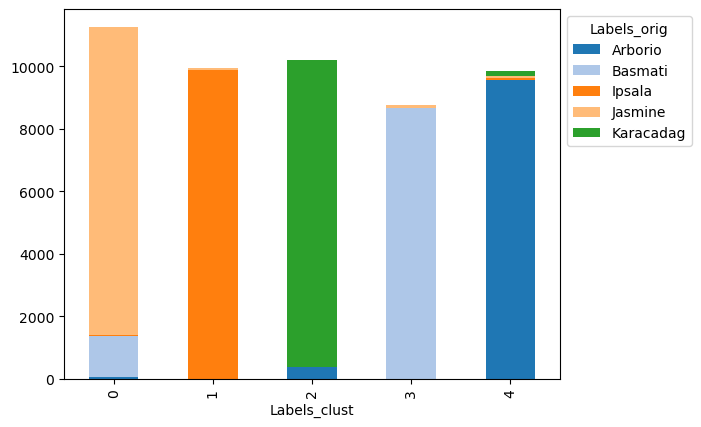

In [11]:
fig, ax = plt.subplots()
cross_tab(sample_labels, cluster_membership).plot(kind="bar", stacked=True, ax=ax, cmap=cmap)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [12]:
cross_tab(sample_labels, cluster_membership)/3000

RAND score=0.9671, Ajusted RAND=0.8973, cantidad_de_muestras=50,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,0.019000,0.440333,0.011333,3.285333,0.000000
1,0.001667,0.000000,3.297333,0.014333,0.000000
2,0.121667,0.000000,0.001333,0.000000,3.275333
3,0.000000,2.893000,0.000333,0.022667,0.000000
4,3.191000,0.000000,0.023000,0.011000,0.058000
